In [1]:
import os
import sys
import pandas as pd
import scanpy as sc

Import SenCID function from api

In [2]:
from SenCID.api import SenCID

G:\software\anaconda\envs\SIDcell\lib\site-packages\kopt\config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [3]:
counts = pd.read_csv('origin_matrix_GSE94980.txt', sep = '\t').T
adata = sc.AnnData(counts)
adata.obs['condition'] = [x.split('_')[-1]=='OSKM' for x in adata.obs_names]

SenCID inputs the raw counts of data, thus it is recommended to process SIDcell before the downstream analysis (etc., scaling or clustering of single cells)

In [4]:
pred_dict, recSID, tmpfiles = SenCID(adata = adata, 
                    sidnums = [1,2,3,4,5,6], 
                    denoising = True, 
                    binarize = True, 
                    threads = 1, 
                    savetmp = True)

Scaling data...
No need to convert to array
dca: Successfully preprocessed 1290 genes and 200 cells.



2023-12-15 18:39:16,822 [WARNING] From G:\software\anaconda\envs\SIDcell\lib\site-packages\dca\train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.



dca: Calculating reconstructions...
Loading models of SID1...
Making predictions of SID1...
Loading models of SID2...
Making predictions of SID2...
Loading models of SID3...
Making predictions of SID3...
Loading models of SID4...
Making predictions of SID4...
Loading models of SID5...
Making predictions of SID5...
Loading models of SID6...
Making predictions of SID6...
Loading Recommend model...
Finished. Giving SID scores and SID Recommendation...


SenCID can also run from the command line:

In [5]:
!SenCID --filepath . --denoising t --fileclass txt --binarize t --save_tmps save_tmps

make dir: ./output
make dir: ./output/save_tmps
1 files detected: 
0 	 origin_matrix_GSE94980
origin_matrix_GSE94980, making adata...
Scaling data...
No need to convert to array
dca: Successfully preprocessed 1290 genes and 200 cells.
dca: Calculating reconstructions...
Loading models of SID1...
Making predictions of SID1...
Loading models of SID2...
Making predictions of SID2...
Loading models of SID3...
Making predictions of SID3...
Loading models of SID4...
Making predictions of SID4...
Loading models of SID5...
Making predictions of SID5...
Loading models of SID6...
Making predictions of SID6...
Loading Recommend model...
Finished. Giving SID scores and SID Recommendation...


2023-12-15 18:39:31.262152: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-12-15 18:39:31.262167: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-15 18:39:32.601602: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-15 18:39:32.602034: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2023-12-15 18:39:32.602045: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-15 18:39:32.603940: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-FVOE1K5
2023-12-15 18:39:32.603977: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:1

The command line will result in an output directory which contains the SenCID predictions for each cell (or sample for bulk RNA-seq), where SID scores are in the 'SID_Score' column, decision function value from SVM are in the 'Decision' column, and the 'Binarization' column refers to crude Senescent(1)-Or-Not(0) judgements by the threshold 0.5 if the parameter 'binary' is set True. Besides, there will be a recommendation dataframe which helps users to decide which SID to use on the specific cell types. Temp files of processed data are stored in the directory given by argument --save_tmps for reproduction.

Now let's visualize the results by a simple pca:

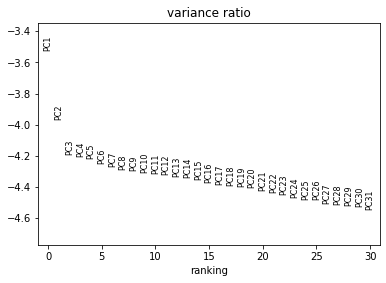

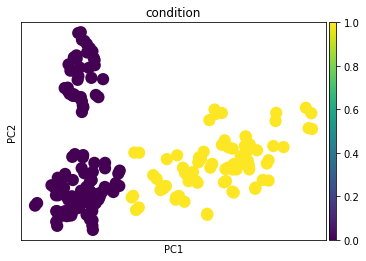

In [6]:
adata.raw = adata

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e5)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack') 
sc.pl.pca_variance_ratio(adata, log=True)
sc.pl.pca(adata, color = ['condition'])

The data.frame recSID gives the recommendation scores of each SID upon each cell.

... storing 'RecSID' as categorical


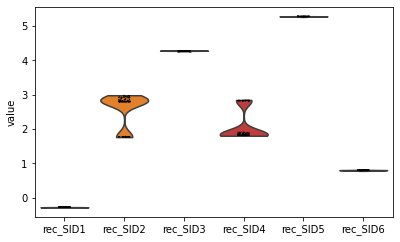

In [7]:
adata.obs = pd.concat([adata.obs, recSID.loc[adata.obs_names, :]], axis = 1)
markers = ['rec_SID1', 'rec_SID2', 'rec_SID3', 'rec_SID4', 'rec_SID5', 'rec_SID6']
sc.pl.violin(adata, keys = markers)

For one single cell type, the SID with the highest recommendation score is considered to be most suitable for senescence evaluation. In this given example, SID5 is used:

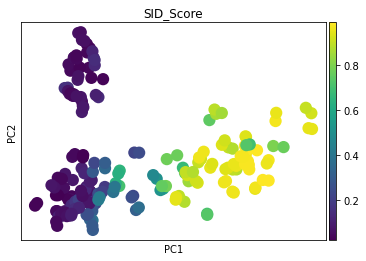

In [8]:
adata.obs['SID_Score'] = pred_dict['SID5'].loc[adata.obs_names, 'SID_Score']
sc.pl.pca(adata, color = ['SID_Score'])